# Making movies for blog

In [ ]:
%load_ext autoreload
%autoreload 2

from graphs import *
from gallagher_algorithm import *
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import pickle
import os
import datetime

First we specify an Eta (a stepsize in the algorithm), and a directory to save

In [2]:
eta = 0.01
savedir = datetime.datetime.now().strftime("%H%M%S") + "_snaps"
os.makedirs(savedir)

Next we generate a Network, either by calling the Constructor or by using a saved network pkl

In [3]:
# From Params
seed = 11
n = 4
np.random.seed(seed)

# Set up quadratic relationship
D_scaling = np.random.randint(1, 7, size=(n,n))
D_func = lambda F: 1/2 * D_scaling * F ** 2
derivD_func = lambda F: D_scaling * F

G = Network(n=n, seed=seed, D_func=D_func, derivD_func=derivD_func, p=0.7)
G.setPhi(shortestPathsPhi(G))


# From Pickle
#G = netFromPickle('4_node.pkl')

Next we run Gallagher's algorithm till it converges. We also visualize what the edge weights look like after Gallagher.

In [4]:
scores, phis = iterGallagher(G, nTrials=30, eta=eta, retPhi=True)
#scores, phis = iterAlgo(G, shortestPathsPhi, nTrials=30, retPhi=True, useCurrentF=True)
phis = np.array(phis)

fs = np.empty_like(phis[:, 0, :, :])
for i, phi in enumerate(phis):
    G.setPhi(phi)
    fs[i] = G.F

assert(convergenceConditions(G))

# Showing F's vs Loss

In [5]:
x = np.arange(len(scores))
x_lim = [min(x) - 1, max(x) + 1]
y_lim = [min(scores) - 1, max(scores) + 1]
nDig = len(str(len(scores) - 1))

wmin = np.min(fs)
wmax = np.max(fs)
mapper = plt.cm.ScalarMappable(Normalize(vmin=wmin, vmax=wmax))

for i, (s, f) in enumerate(zip(scores, fs)):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
    
    # Convergence plot
    ax1.set_xlim(x_lim); ax1.set_ylim(y_lim)
    ax1.plot(x[:i+1], scores[:i+1], 'b-')
    ax1.scatter([i], [s], c='r')
    ax1.set_xlabel('# of iterations of algorithm'); ax1.set_ylabel('D_T (Expected delay)')
    
    # Graph viz
    G.visualizeWithColors(ax=ax2, wMat=f, mapper=mapper, \
                          weight_min=wmin, weight_max=wmax, \
                          withLabels=True, arcEdges=False)
    ax2.set_title('Traffic on Edges');
    ax2.axis('off')
    
    # Colorbar
    plt.colorbar(mappable=mapper, ax=ax2)
    
    plt.savefig(os.path.join(savedir, str(i).zfill(nDig) + '.jpg'))
    plt.close()

In [6]:
savedir = datetime.datetime.now().strftime("%H%M%S") + "_snaps"
os.makedirs(savedir)

# Showing PHI's vs Loss

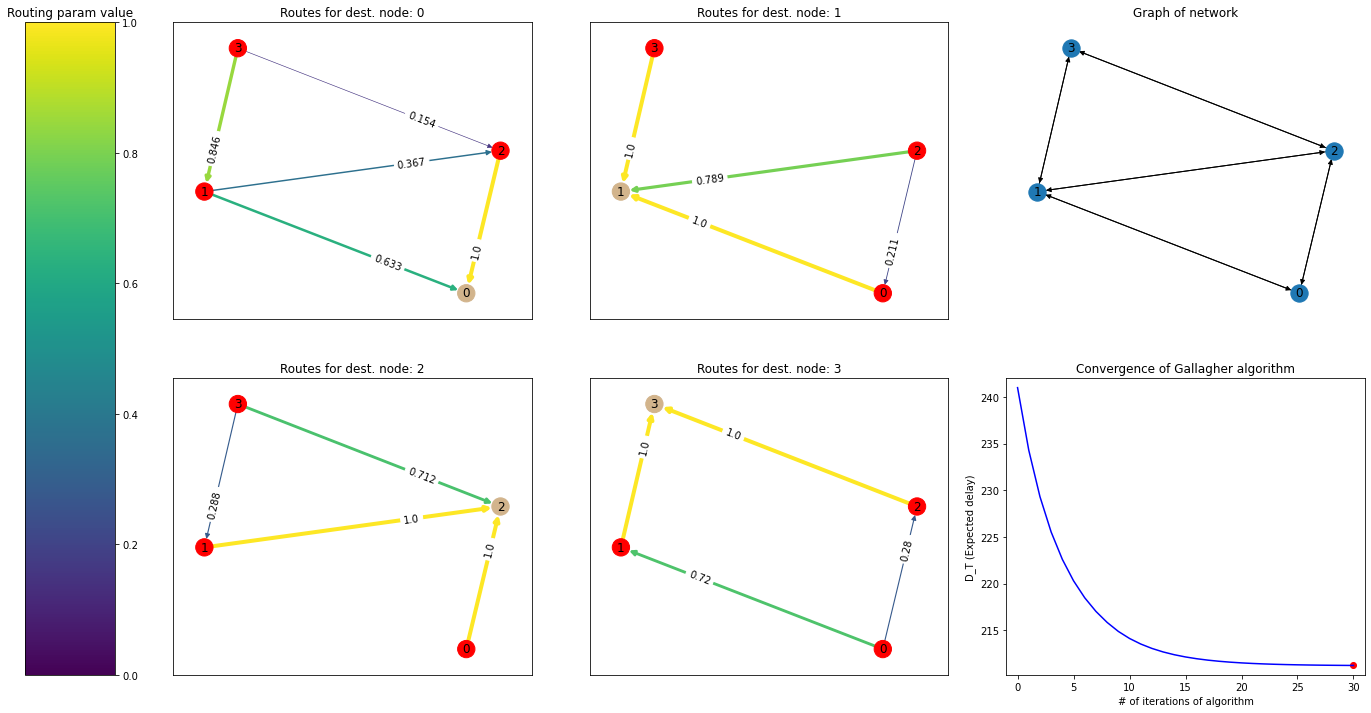

In [7]:
x = np.arange(len(scores))
x_lim = [min(x) - 1, max(x) + 1]
y_lim = [min(scores) - 1, max(scores) + 1]
nDig = len(str(len(scores) - 1))

wmin = np.min(phis)
wmax = np.max(phis)
#wmax = np.max(phis, axis=(0, 2, 3))
mapper = plt.cm.ScalarMappable(Normalize(vmin=wmin, vmax=wmax))

f = plt.figure()
f.set_size_inches(24, 12)
gs0 = gridspec.GridSpec(2, 4, width_ratios=(1,4,4,4), figure=f)
phi_ax  = [f.add_subplot(gs0[i, j]) for i,j in [(0,1), (0, 2), (1, 1), (1,2)]]
cbar_ax = f.add_subplot(gs0[:, 0])
og_ax   = f.add_subplot(gs0[0, 3])
plt_ax  = f.add_subplot(gs0[1, 3])

# Colorbar
plt.colorbar(mappable=mapper, cax=cbar_ax)
cbar_ax.set_title('Routing param value')

# Og Graph
G.visualize(withEdgeTraffic=False, ax=og_ax)
og_ax.set_title('Graph of network')
og_ax.axis('off')

for i, (s, phi) in enumerate(zip(scores, phis)): 
    # Graph viz
    for j, (sub_phi, ax) in enumerate(zip(phi, phi_ax)):
        ax.clear()
        G.visualizeWithColors(ax=ax, wMat=sub_phi, withLabels=True, mapper=mapper, \
                              weight_min=wmin, weight_max=wmax, dst_node=j)
        ax.set_title(f'Routes for dest. node: {j}')
    
    # Convergence plot
    plt_ax.clear()
    plt_ax.set_xlim(x_lim); plt_ax.set_ylim(y_lim);
    plt_ax.plot(x[:i+1], scores[:i+1], 'b-')
    plt_ax.scatter([i], [s], c='r')
    plt_ax.set_xlabel('# of iterations of algorithm'); plt_ax.set_ylabel('D_T (Expected delay)');
    plt_ax.set_title('Convergence of Gallagher algorithm')
    
    plt.savefig(os.path.join(savedir, str(i).zfill(nDig) + '.jpg'))